# DQAN: DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [2]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.00656088 -0.14912214 -0.04014852  0.26801559] 0 1.0 False {}
state, action, reward, done, info
[ 0.00357843  0.04654911 -0.0347882  -0.03705524] 1 1.0 False {}
state, action, reward, done, info
[ 0.00450942  0.24215221 -0.03552931 -0.34050804] 1 1.0 False {}
state, action, reward, done, info
[ 0.00935246  0.04755332 -0.04233947 -0.05923734] 0 1.0 False {}
state, action, reward, done, info
[ 0.01030353  0.24325595 -0.04352422 -0.3649723 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.01516865  0.43896855 -0.05082366 -0.67105526] 1 1.0 False {}
state, action, reward, done, info
[ 0.02394802  0.63475884 -0.06424477 -0.97929721] 1 1.0 False {}
state, action, reward, done, info
[ 0.03664319  0.83068047 -0.08383071 -1.29144834] 1 1.0 False {}
state, action, reward, done, info
[ 0.0532568   1.02676221 -0.10965968 -1.60915545] 1 1.0 False {}
state, action, reward, done, info
[ 0.07379205  1.22299582 -0.14184279 -1.93391319] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.22299582295005 -1.9339131861641197


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [7]:
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        return logits

In [8]:
def discriminator(actions, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [9]:
def model_loss(states, actions, action_size, hidden_size, state_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, 
                               state_size=state_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, action_size=action_size)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, action_size=action_size, 
                                  reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake

In [10]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [11]:
class QNetwork:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [14]:
tf.reset_default_graph()
model = QNetwork(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            feed_dict={model.states: next_states}
            next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = next_rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

Episode: 0 Total reward: 2.0 Training d_loss: 1.3830 Training g_loss: 0.6841 Training q_loss: 0.5192 Explore P: 0.9998
Episode: 1 Total reward: 19.0 Training d_loss: 1.2352 Training g_loss: 0.7737 Training q_loss: 0.4918 Explore P: 0.9979
Episode: 2 Total reward: 9.0 Training d_loss: 1.1859 Training g_loss: 0.7918 Training q_loss: 1.3040 Explore P: 0.9970
Episode: 3 Total reward: 14.0 Training d_loss: 1.1632 Training g_loss: 0.7876 Training q_loss: 3.6075 Explore P: 0.9957
Episode: 4 Total reward: 46.0 Training d_loss: 1.1178 Training g_loss: 0.9200 Training q_loss: 7.4019 Explore P: 0.9911
Episode: 5 Total reward: 17.0 Training d_loss: 1.2273 Training g_loss: 0.8286 Training q_loss: 14.2734 Explore P: 0.9895
Episode: 6 Total reward: 12.0 Training d_loss: 1.1514 Training g_loss: 1.0090 Training q_loss: 6.1049 Explore P: 0.9883
Episode: 7 Total reward: 16.0 Training d_loss: 1.1359 Training g_loss: 1.0124 Training q_loss: 25.3727 Explore P: 0.9867
Episode: 8 Total reward: 20.0 Training d

Episode: 69 Total reward: 23.0 Training d_loss: 1.3018 Training g_loss: 0.7375 Training q_loss: 28.2213 Explore P: 0.8685
Episode: 70 Total reward: 20.0 Training d_loss: 1.3535 Training g_loss: 0.9010 Training q_loss: 107.0749 Explore P: 0.8668
Episode: 71 Total reward: 14.0 Training d_loss: 1.2582 Training g_loss: 0.8446 Training q_loss: 32.3859 Explore P: 0.8656
Episode: 72 Total reward: 88.0 Training d_loss: 1.4020 Training g_loss: 0.6907 Training q_loss: 72.6068 Explore P: 0.8581
Episode: 73 Total reward: 11.0 Training d_loss: 1.2905 Training g_loss: 1.2243 Training q_loss: 18.1432 Explore P: 0.8572
Episode: 74 Total reward: 16.0 Training d_loss: 1.1795 Training g_loss: 0.8760 Training q_loss: 31.9393 Explore P: 0.8558
Episode: 75 Total reward: 12.0 Training d_loss: 1.3879 Training g_loss: 0.8832 Training q_loss: 45.9666 Explore P: 0.8548
Episode: 76 Total reward: 11.0 Training d_loss: 1.3655 Training g_loss: 0.9777 Training q_loss: 24.4077 Explore P: 0.8539
Episode: 77 Total rewar

Episode: 136 Total reward: 101.0 Training d_loss: 1.3125 Training g_loss: 0.7522 Training q_loss: 3226.3022 Explore P: 0.6933
Episode: 137 Total reward: 33.0 Training d_loss: 1.4055 Training g_loss: 0.6127 Training q_loss: 57.5578 Explore P: 0.6910
Episode: 138 Total reward: 63.0 Training d_loss: 1.1969 Training g_loss: 0.9039 Training q_loss: 194.4655 Explore P: 0.6868
Episode: 139 Total reward: 23.0 Training d_loss: 1.4810 Training g_loss: 0.7251 Training q_loss: 6434.2080 Explore P: 0.6852
Episode: 140 Total reward: 13.0 Training d_loss: 1.2810 Training g_loss: 0.9302 Training q_loss: 241.2480 Explore P: 0.6843
Episode: 141 Total reward: 18.0 Training d_loss: 1.3504 Training g_loss: 0.7097 Training q_loss: 5104.7407 Explore P: 0.6831
Episode: 142 Total reward: 31.0 Training d_loss: 1.3604 Training g_loss: 0.7136 Training q_loss: 675.3869 Explore P: 0.6810
Episode: 143 Total reward: 121.0 Training d_loss: 1.4356 Training g_loss: 0.6339 Training q_loss: 237.7728 Explore P: 0.6730
Epis

Episode: 202 Total reward: 119.0 Training d_loss: 1.3826 Training g_loss: 0.6891 Training q_loss: 29994.9414 Explore P: 0.3827
Episode: 203 Total reward: 113.0 Training d_loss: 1.3211 Training g_loss: 0.6886 Training q_loss: 2994.5364 Explore P: 0.3785
Episode: 204 Total reward: 158.0 Training d_loss: 1.3935 Training g_loss: 0.6715 Training q_loss: 584.3666 Explore P: 0.3727
Episode: 205 Total reward: 199.0 Training d_loss: 1.3959 Training g_loss: 0.6705 Training q_loss: 1003.6022 Explore P: 0.3656
Episode: 206 Total reward: 199.0 Training d_loss: 1.4406 Training g_loss: 0.6719 Training q_loss: 834.0086 Explore P: 0.3586
Episode: 207 Total reward: 193.0 Training d_loss: 1.3653 Training g_loss: 0.6811 Training q_loss: 299.0294 Explore P: 0.3519
Episode: 208 Total reward: 199.0 Training d_loss: 1.3213 Training g_loss: 0.7771 Training q_loss: 449.4674 Explore P: 0.3452
Episode: 209 Total reward: 24.0 Training d_loss: 1.3964 Training g_loss: 0.6643 Training q_loss: 462.7298 Explore P: 0.34

Episode: 268 Total reward: 199.0 Training d_loss: 1.3467 Training g_loss: 0.7126 Training q_loss: 51.4991 Explore P: 0.1225
Episode: 269 Total reward: 199.0 Training d_loss: 1.1983 Training g_loss: 3.0473 Training q_loss: 67.4182 Explore P: 0.1203
Episode: 270 Total reward: 199.0 Training d_loss: 1.1875 Training g_loss: 2.0257 Training q_loss: 95.5106 Explore P: 0.1181
Episode: 271 Total reward: 199.0 Training d_loss: 1.1191 Training g_loss: 2.0690 Training q_loss: 27.3672 Explore P: 0.1160
Episode: 272 Total reward: 199.0 Training d_loss: 1.1323 Training g_loss: 3.1628 Training q_loss: 20.4127 Explore P: 0.1139
Episode: 273 Total reward: 199.0 Training d_loss: 1.2244 Training g_loss: 0.8163 Training q_loss: 28.3440 Explore P: 0.1119
Episode: 274 Total reward: 199.0 Training d_loss: 1.2262 Training g_loss: 1.0968 Training q_loss: 58.5725 Explore P: 0.1099
Episode: 275 Total reward: 199.0 Training d_loss: 1.0338 Training g_loss: 4.5659 Training q_loss: 34.8613 Explore P: 0.1079
Episode:

Episode: 334 Total reward: 199.0 Training d_loss: 1.3016 Training g_loss: 1.2793 Training q_loss: 41.8432 Explore P: 0.0459
Episode: 335 Total reward: 199.0 Training d_loss: 1.3295 Training g_loss: 2.8204 Training q_loss: 724.0529 Explore P: 0.0452
Episode: 336 Total reward: 199.0 Training d_loss: 1.2822 Training g_loss: 4.2679 Training q_loss: 19.2509 Explore P: 0.0445
Episode: 337 Total reward: 199.0 Training d_loss: 1.3504 Training g_loss: 2.6535 Training q_loss: 2336.6318 Explore P: 0.0438
Episode: 338 Total reward: 199.0 Training d_loss: 1.1792 Training g_loss: 3.1269 Training q_loss: 78.1063 Explore P: 0.0431
Episode: 339 Total reward: 199.0 Training d_loss: 0.9870 Training g_loss: 3.2095 Training q_loss: 26.5622 Explore P: 0.0425
Episode: 340 Total reward: 199.0 Training d_loss: 1.3196 Training g_loss: 1.0054 Training q_loss: 85.4963 Explore P: 0.0418
Episode: 341 Total reward: 199.0 Training d_loss: 1.3155 Training g_loss: 1.6400 Training q_loss: 1823.3105 Explore P: 0.0412
Epi

Episode: 401 Total reward: 161.0 Training d_loss: 1.0807 Training g_loss: 2.8373 Training q_loss: 1.8405 Explore P: 0.0197
Episode: 402 Total reward: 199.0 Training d_loss: 1.3615 Training g_loss: 0.7670 Training q_loss: 3.3960 Explore P: 0.0195
Episode: 403 Total reward: 199.0 Training d_loss: 1.3311 Training g_loss: 0.7843 Training q_loss: 7.8832 Explore P: 0.0194
Episode: 404 Total reward: 151.0 Training d_loss: 1.3084 Training g_loss: 0.8694 Training q_loss: 20.0971 Explore P: 0.0192
Episode: 405 Total reward: 151.0 Training d_loss: 1.1054 Training g_loss: 1.4140 Training q_loss: 5.6591 Explore P: 0.0191
Episode: 406 Total reward: 128.0 Training d_loss: 1.0803 Training g_loss: 5.3300 Training q_loss: 7.7167 Explore P: 0.0190
Episode: 407 Total reward: 151.0 Training d_loss: 1.3683 Training g_loss: 1.0054 Training q_loss: 8.3113 Explore P: 0.0188
Episode: 408 Total reward: 123.0 Training d_loss: 1.2129 Training g_loss: 0.7252 Training q_loss: 20.0816 Explore P: 0.0187
Episode: 409 T

Episode: 468 Total reward: 135.0 Training d_loss: 1.2126 Training g_loss: 4.5532 Training q_loss: 24.9202 Explore P: 0.0139
Episode: 469 Total reward: 115.0 Training d_loss: 1.4203 Training g_loss: 0.6240 Training q_loss: 4.7768 Explore P: 0.0139
Episode: 470 Total reward: 119.0 Training d_loss: 1.2925 Training g_loss: 2.5217 Training q_loss: 25.4296 Explore P: 0.0138
Episode: 471 Total reward: 100.0 Training d_loss: 1.1238 Training g_loss: 9.5794 Training q_loss: 3.0434 Explore P: 0.0138
Episode: 472 Total reward: 117.0 Training d_loss: 1.3645 Training g_loss: 2.9144 Training q_loss: 19.7103 Explore P: 0.0137
Episode: 473 Total reward: 118.0 Training d_loss: 1.1328 Training g_loss: 2.2968 Training q_loss: 23.3469 Explore P: 0.0137
Episode: 474 Total reward: 99.0 Training d_loss: 1.0677 Training g_loss: 10.4918 Training q_loss: 12.2072 Explore P: 0.0137
Episode: 475 Total reward: 121.0 Training d_loss: 1.3005 Training g_loss: 5.4355 Training q_loss: 19.0380 Explore P: 0.0136
Episode: 4

Episode: 535 Total reward: 199.0 Training d_loss: 0.8786 Training g_loss: 8.1927 Training q_loss: 12.0790 Explore P: 0.0120
Episode: 536 Total reward: 199.0 Training d_loss: 1.2757 Training g_loss: 2.3152 Training q_loss: 122.5334 Explore P: 0.0119
Episode: 537 Total reward: 184.0 Training d_loss: 1.3826 Training g_loss: 3.1549 Training q_loss: 69.7261 Explore P: 0.0119
Episode: 538 Total reward: 199.0 Training d_loss: 1.1168 Training g_loss: 0.9713 Training q_loss: 53.3777 Explore P: 0.0119
Episode: 539 Total reward: 171.0 Training d_loss: 1.2143 Training g_loss: 5.9100 Training q_loss: 13.2103 Explore P: 0.0118
Episode: 540 Total reward: 199.0 Training d_loss: 1.3258 Training g_loss: 1.8552 Training q_loss: 50.9156 Explore P: 0.0118
Episode: 541 Total reward: 199.0 Training d_loss: 1.2100 Training g_loss: 9.8787 Training q_loss: 8.9153 Explore P: 0.0118
Episode: 542 Total reward: 199.0 Training d_loss: 1.2780 Training g_loss: 5.7160 Training q_loss: 6.3378 Explore P: 0.0117
Episode: 

Episode: 602 Total reward: 161.0 Training d_loss: 1.1111 Training g_loss: 13.6625 Training q_loss: 13.9426 Explore P: 0.0106
Episode: 603 Total reward: 103.0 Training d_loss: 1.2318 Training g_loss: 7.7513 Training q_loss: 15.6046 Explore P: 0.0106
Episode: 604 Total reward: 174.0 Training d_loss: 1.3664 Training g_loss: 0.7044 Training q_loss: 2.3574 Explore P: 0.0106
Episode: 605 Total reward: 166.0 Training d_loss: 1.2890 Training g_loss: 0.8984 Training q_loss: 10.6456 Explore P: 0.0106
Episode: 606 Total reward: 149.0 Training d_loss: 1.3389 Training g_loss: 1.5417 Training q_loss: 14.6128 Explore P: 0.0106
Episode: 607 Total reward: 137.0 Training d_loss: 1.3801 Training g_loss: 0.6366 Training q_loss: 4.6369 Explore P: 0.0106
Episode: 608 Total reward: 158.0 Training d_loss: 1.1802 Training g_loss: 8.2289 Training q_loss: 3.6761 Explore P: 0.0105
Episode: 609 Total reward: 165.0 Training d_loss: 1.3284 Training g_loss: 1.9137 Training q_loss: 15.2535 Explore P: 0.0105
Episode: 6

Episode: 669 Total reward: 113.0 Training d_loss: 1.2772 Training g_loss: 2.5124 Training q_loss: 5.8666 Explore P: 0.0103
Episode: 670 Total reward: 125.0 Training d_loss: 1.4213 Training g_loss: 0.5757 Training q_loss: 3.9240 Explore P: 0.0103
Episode: 671 Total reward: 118.0 Training d_loss: 1.1686 Training g_loss: 8.8792 Training q_loss: 5.3128 Explore P: 0.0103
Episode: 672 Total reward: 120.0 Training d_loss: 1.3891 Training g_loss: 0.7415 Training q_loss: 1.3676 Explore P: 0.0103
Episode: 673 Total reward: 127.0 Training d_loss: 1.2626 Training g_loss: 8.7115 Training q_loss: 5.3105 Explore P: 0.0103
Episode: 674 Total reward: 102.0 Training d_loss: 1.3781 Training g_loss: 0.6664 Training q_loss: 5.4769 Explore P: 0.0103
Episode: 675 Total reward: 155.0 Training d_loss: 1.3135 Training g_loss: 0.9502 Training q_loss: 2.4129 Explore P: 0.0102
Episode: 676 Total reward: 121.0 Training d_loss: 1.2233 Training g_loss: 15.6072 Training q_loss: 54.7657 Explore P: 0.0102
Episode: 677 T

Episode: 736 Total reward: 13.0 Training d_loss: 0.8071 Training g_loss: 1.8867 Training q_loss: 3609.1929 Explore P: 0.0102
Episode: 737 Total reward: 13.0 Training d_loss: 0.8589 Training g_loss: 5.8780 Training q_loss: 3371.3403 Explore P: 0.0102
Episode: 738 Total reward: 13.0 Training d_loss: 0.9894 Training g_loss: 1.1664 Training q_loss: 5762.5815 Explore P: 0.0102
Episode: 739 Total reward: 15.0 Training d_loss: 1.1236 Training g_loss: 1.3777 Training q_loss: 4924.7305 Explore P: 0.0102
Episode: 740 Total reward: 18.0 Training d_loss: 1.0908 Training g_loss: 1.0508 Training q_loss: 7152.7251 Explore P: 0.0102
Episode: 741 Total reward: 15.0 Training d_loss: 1.2520 Training g_loss: 1.2780 Training q_loss: 7528.3936 Explore P: 0.0102
Episode: 742 Total reward: 15.0 Training d_loss: 1.2200 Training g_loss: 1.2532 Training q_loss: 7517.1377 Explore P: 0.0102
Episode: 743 Total reward: 17.0 Training d_loss: 1.0979 Training g_loss: 1.1743 Training q_loss: 1835.1703 Explore P: 0.0102


Episode: 802 Total reward: 98.0 Training d_loss: 1.3980 Training g_loss: 0.5702 Training q_loss: 1250.8759 Explore P: 0.0101
Episode: 803 Total reward: 172.0 Training d_loss: 1.2943 Training g_loss: 0.9185 Training q_loss: 598.3201 Explore P: 0.0101
Episode: 804 Total reward: 91.0 Training d_loss: 1.2807 Training g_loss: 1.0384 Training q_loss: 769.0616 Explore P: 0.0101
Episode: 805 Total reward: 143.0 Training d_loss: 1.0121 Training g_loss: 0.9452 Training q_loss: 456.5778 Explore P: 0.0101
Episode: 806 Total reward: 58.0 Training d_loss: 1.2229 Training g_loss: 0.9653 Training q_loss: 1131.1536 Explore P: 0.0101
Episode: 807 Total reward: 67.0 Training d_loss: 1.1699 Training g_loss: 7.7926 Training q_loss: 770.8448 Explore P: 0.0101
Episode: 808 Total reward: 60.0 Training d_loss: 1.1852 Training g_loss: 0.8651 Training q_loss: 1990.9387 Explore P: 0.0101
Episode: 809 Total reward: 67.0 Training d_loss: 1.1553 Training g_loss: 3.5471 Training q_loss: 429.2469 Explore P: 0.0101
Epi

Episode: 868 Total reward: 19.0 Training d_loss: 1.3208 Training g_loss: 0.6937 Training q_loss: 97.3609 Explore P: 0.0101
Episode: 869 Total reward: 19.0 Training d_loss: 1.3263 Training g_loss: 0.7291 Training q_loss: 545.9496 Explore P: 0.0101
Episode: 870 Total reward: 40.0 Training d_loss: 1.2552 Training g_loss: 7.3851 Training q_loss: 1034.3032 Explore P: 0.0101
Episode: 871 Total reward: 82.0 Training d_loss: 1.3283 Training g_loss: 0.6322 Training q_loss: 600.4856 Explore P: 0.0101
Episode: 872 Total reward: 144.0 Training d_loss: 1.3285 Training g_loss: 0.8279 Training q_loss: 206.7463 Explore P: 0.0101
Episode: 873 Total reward: 110.0 Training d_loss: 1.1639 Training g_loss: 0.9871 Training q_loss: 804.6430 Explore P: 0.0101
Episode: 874 Total reward: 74.0 Training d_loss: 1.1968 Training g_loss: 0.9688 Training q_loss: 686.9255 Explore P: 0.0101
Episode: 875 Total reward: 64.0 Training d_loss: 1.1114 Training g_loss: 0.9779 Training q_loss: 397.3913 Explore P: 0.0101
Episod

Episode: 934 Total reward: 189.0 Training d_loss: 1.2497 Training g_loss: 0.8565 Training q_loss: 243.2249 Explore P: 0.0100
Episode: 935 Total reward: 114.0 Training d_loss: 1.1676 Training g_loss: 2.3771 Training q_loss: 173.5432 Explore P: 0.0100
Episode: 936 Total reward: 121.0 Training d_loss: 1.2294 Training g_loss: 5.5262 Training q_loss: 267.0475 Explore P: 0.0100
Episode: 937 Total reward: 107.0 Training d_loss: 1.2958 Training g_loss: 4.5340 Training q_loss: 224.7875 Explore P: 0.0100
Episode: 938 Total reward: 120.0 Training d_loss: 1.5091 Training g_loss: 5.0365 Training q_loss: 188.8164 Explore P: 0.0100
Episode: 939 Total reward: 115.0 Training d_loss: 1.2189 Training g_loss: 2.3378 Training q_loss: 220.6620 Explore P: 0.0100
Episode: 940 Total reward: 116.0 Training d_loss: 1.2570 Training g_loss: 4.5294 Training q_loss: 376.4562 Explore P: 0.0100
Episode: 941 Total reward: 124.0 Training d_loss: 1.2927 Training g_loss: 0.8304 Training q_loss: 197.4508 Explore P: 0.0100


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

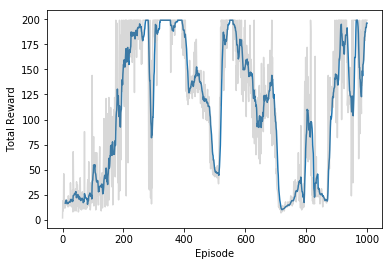

In [18]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(test_episodes):
        t = 0
        while t < test_max_steps:
            # env.render() 
            
            # Get action from Q-network
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            targetQ = sess.run(model.outputs, feed_dict)
            action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.